In [51]:
import tensorflow as tf

from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3

from keras.preprocessing import image

import os
import random
import numpy as np
from shutil import move
import csv

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
base_dir = './data/input/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_dir = os.path.join(base_dir, 'test')

In [3]:
required_directories = [train_dir, validation_dir, train_cats_dir, 
                        train_dogs_dir, validation_cats_dir, validation_dogs_dir, 
                        test_dir]

for required_dir in required_directories:
    try:
        os.mkdir(required_dir)
    except OSError:
        print("-----------------------------------------------------------")
        print("... Skipping folder at path   <<< {} >>>\n... It already exists".format(required_dir.split(base_dir)[1]))
        print("-----------------------------------------------------------\n")
        continue

-----------------------------------------------------------
... Skipping folder at path   <<< train >>>
... It already exists
-----------------------------------------------------------

-----------------------------------------------------------
... Skipping folder at path   <<< test >>>
... It already exists
-----------------------------------------------------------



In [5]:
def split_data(src_folder, train_folder, val_folder, split_ratio, filter_by=""):
    
    # Verify that there are enough files in the src_folder...
    # This will also allow this cell to be run after the initial setup run without error
    if len(os.listdir(src_folder)) < 50:
        print("Cancelling as less than 50 files/folders were found.\n\nCheck the src_folder path and try again")
        return

    file_list = []
        
    for f_name in os.listdir(src_folder):
        file_path = os.path.join(src_folder, f_name)

        # Check that the file is not a directory (if it is than continue to the next file)
        if os.path.isdir(file_path):
            print(f_name + " is directory, so ignoring.")
            continue
        
        # Check that file is not empty
        if os.path.getsize(file_path) > 0:
            if filter_by is "" or str(filter_by) in f_name:
                file_list.append(f_name)
        else:
            print(f_name + " is zero length, so ignoring.")
            
    train_len = int(len(file_list) * split_ratio)
    val_len = int(len(file_list) - train_len)

    shuffled_files = random.sample(file_list, len(file_list))
    train_files = shuffled_files[:train_len]
    val_files = shuffled_files[-val_len:]

    for f_name in train_files:
        file_path = os.path.join(src_folder, f_name)
        dest_path = os.path.join(train_folder, f_name)
        move(file_path, dest_path)

    for f_name in val_files:
        file_path = os.path.join(src_folder, f_name)
        dest_path = os.path.join(val_folder, f_name)
        move(file_path, dest_path)

In [6]:
# Train Directory Cats Split Into Train/Cats Directory Cats and Train/Val Directory Cats
split_data(src_folder=train_dir, 
           train_folder=train_cats_dir, 
           val_folder=validation_cats_dir, 
           split_ratio=0.975, 
           filter_by="cat")

# Train Directory Dogs Split Into Train/Cats Directory Dogs and Train/Val Directory Dogs
split_data(src_folder=train_dir, 
           train_folder=train_dogs_dir, 
           val_folder=validation_dogs_dir, 
           split_ratio=0.975, 
           filter_by="dog")

cats is directory, so ignoring.
dogs is directory, so ignoring.
cats is directory, so ignoring.
dogs is directory, so ignoring.


In [7]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

print('total test images :', len(os.listdir(test_dir)))

total training cat images : 12187
total training dog images : 12187
total validation cat images : 313
total validation dog images : 313
total test images : 12500


Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

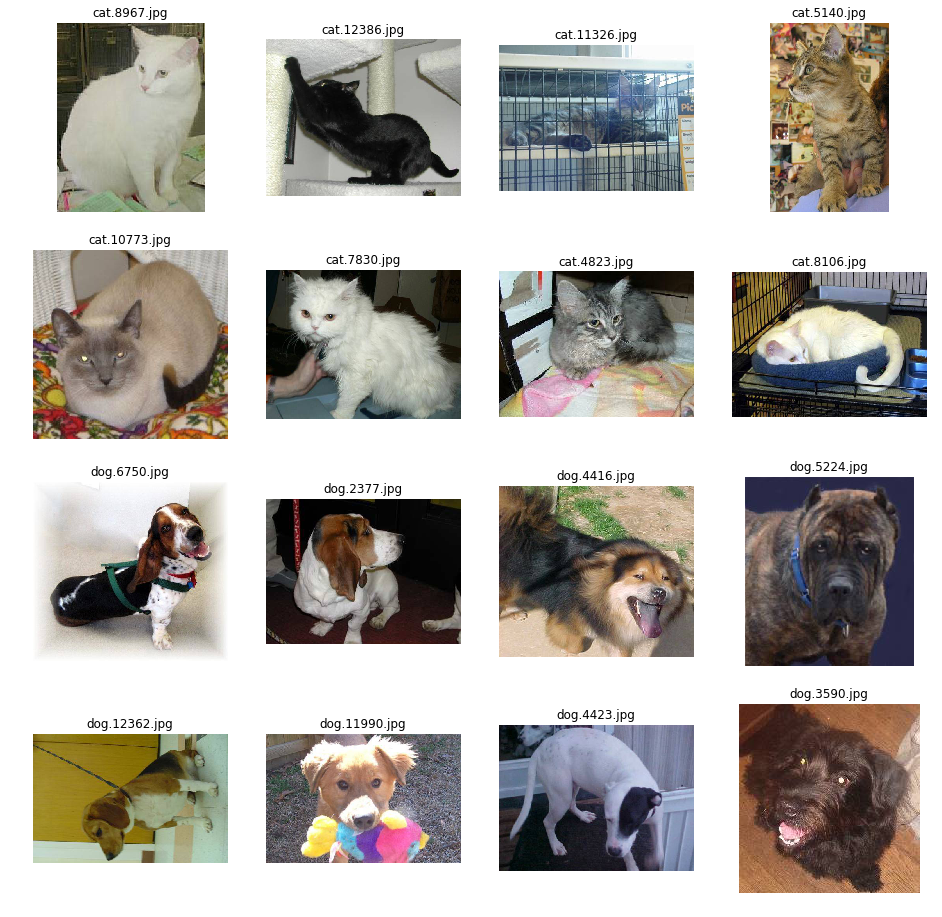

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    subp = plt.subplot(nrows, ncols, i + 1)
    subp.axis('Off') # Don't show axes (or gridlines)
    subp.set_title(img_path.split("/")[-1])
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [13]:
# Download the pre_trained model we will be using for transfer learning
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Print the massive model summary
pre_trained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_95 

In [14]:
# Pick the layer we wish to use as the input for our cats_v_dogs model
#
# Note: Mixed layers are good choices as they occur directly after concatenation of activations

# Retrieve the output vector from the chosen last layer
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 7, 7, 768)


In [15]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.25)(x)                  

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.25)(x)                  

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.compile(optimizer = Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_95 

In [17]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 44,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.15,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen  = ImageDataGenerator(rescale = 1./255.)

# --------------------
# Flow training images in batches of 64 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 64 using val_datagen generator
# --------------------
validation_generator =  val_datagen.flow_from_directory(validation_dir,
                                                         batch_size=64,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 24374 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


In [22]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.985):
            print("\nReached {} accuracy, so stopping training!!".format(str(98.5)))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [82]:
train_n = len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))
val_n = len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir))
passes_through_n = 2


history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=int(train_n*passes_through_n),
                              epochs=10,
                              validation_steps=int(val_n),
                              callbacks=[callbacks],
                              verbose=1)

Epoch 1/10
381/381 [==============================] - 181s 475ms/step - loss: 0.2268 - acc: 0.9049 - val_loss: 0.2034 - val_acc: 0.9473
Epoch 2/10
381/381 [==============================] - 179s 469ms/step - loss: 0.2226 - acc: 0.9060 - val_loss: 0.1816 - val_acc: 0.9521
Epoch 3/10
381/381 [==============================] - 180s 471ms/step - loss: 0.2201 - acc: 0.9070 - val_loss: 0.2388 - val_acc: 0.9441
Epoch 4/10
381/381 [==============================] - 180s 471ms/step - loss: 0.2216 - acc: 0.9065 - val_loss: 0.2223 - val_acc: 0.9441
Epoch 5/10
381/381 [==============================] - 180s 472ms/step - loss: 0.2178 - acc: 0.9063 - val_loss: 0.1962 - val_acc: 0.9521
Epoch 6/10
381/381 [==============================] - 179s 470ms/step - loss: 0.2101 - acc: 0.9107 - val_loss: 0.1936 - val_acc: 0.9585
Epoch 7/10
381/381 [==============================] - 180s 473ms/step - loss: 0.2098 - acc: 0.9108 - val_loss: 0.2165 - val_acc: 0.9505
Epoch 8/10
381/381 [============================

In [83]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

# predicting images
test_files = os.listdir(test_dir)
sample_files = random.sample(test_files, 9)

for i, img_path in enumerate(sample_files):

    img=image.load_img(os.path.join(test_dir, img_path), target_size=(220, 220))

    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)

    class_pred = model.predict(x, batch_size=1)

    
    # Set up subplot; subplot indices start at 1
    subp = plt.subplot(nrows, ncols, i + 1)
    subp.axis('Off') # Don't show axes (or gridlines)

    if class_pred>0:
        subp.title.set_text(img_path + " is a good hair")

    else:
        subp.title.set_text(img_path + " is a bad hair")
    
    img = mpimg.imread(os.path.join(test_dir, img_path))
    plt.imshow(img)

plt.show()


ValueError: Sample larger than population or is negative

<Figure size 1152x1152 with 0 Axes>

In [ ]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in os.listdir(train_cats_dir)]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in os.listdir(train_dogs_dir)]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [88]:
ids = []
predictions = []
for f_path in os.listdir(os.path.join(test_dir, "unknown")):
    img = image.load_img(os.path.join(os.path.join(test_dir, "unknown"), f_path), target_size=(150, 150))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    prediction = np.clip(model.predict(img)[0][0], 0.1,0.9)
    predictions.append(prediction)
    
    idx = f_path.split(".jpg")[0]
    ids.append(idx)
    
    print(idx, prediction)

7998 0.47518048
10678 0.9
10815 0.9
1185 0.47518048
6097 0.9
6555 0.9
5864 0.47518048
8683 0.9
9731 0.9
10622 0.47518048
2658 0.8864992
30 0.47518048
8259 0.9
755 0.9
6746 0.20713311
2347 0.1
8660 0.47518048
10931 0.47518048
8162 0.9
7335 0.1
2295 0.47518048
8476 0.1
9506 0.9
4677 0.9
4357 0.9
12424 0.47518048
5312 0.9
2797 0.1
6228 0.9
8563 0.47518048
9326 0.9
4981 0.9
10127 0.47518048
12409 0.9
7244 0.9
10834 0.47518048
10224 0.9
11067 0.1
9828 0.47518048
9571 0.9
2863 0.47367522
6826 0.1
248 0.1
5938 0.9
7473 0.9
8773 0.47518048
8679 0.47518048
4241 0.9
5452 0.1
11022 0.47518048
1769 0.47518048
602 0.9
121 0.9
4204 0.9
7010 0.47518048
11659 0.9
9563 0.9
1559 0.3271193
8553 0.1
2488 0.9
10272 0.18792598
473 0.1
292 0.9
4484 0.9
5533 0.1
3620 0.9
5736 0.47518048
3988 0.9
4480 0.78286076
11338 0.47518048
11986 0.9
7646 0.47518048
4146 0.9
10276 0.1
9382 0.47518048
10265 0.47518048
1216 0.9
5048 0.47518048
1223 0.9
7337 0.80862284
11884 0.47518048
646 0.9
819 0.1
11186 0.9
6755 0.9
6945

6217 0.1
5292 0.9
12071 0.9
9622 0.9
6493 0.10012942
6208 0.2260769
10318 0.9
11641 0.20803238
10927 0.1
5433 0.9
1823 0.9
10787 0.1
4957 0.47518048
12301 0.47518048
12015 0.9
11151 0.9
1729 0.9
6238 0.9
10356 0.9
1138 0.47518048
12102 0.9
8750 0.23246992
11448 0.1
11235 0.9
7809 0.47518048
7794 0.9
2610 0.53538907
10399 0.1
2307 0.1
5604 0.9
1092 0.47518048
5320 0.9
2374 0.1
5367 0.47518048
9788 0.9
6756 0.47518048
5833 0.9
4800 0.47518048
11045 0.9
4817 0.47518048
10797 0.1
636 0.9
2266 0.9
3695 0.9
5690 0.47518048
1420 0.9
6337 0.9
3745 0.47518048
394 0.1
11752 0.1
1899 0.47518048
624 0.1
7425 0.9
3356 0.47518048
11668 0.9
4461 0.47518048
492 0.1
4058 0.9
6264 0.9
8362 0.105835564
6526 0.47518048
5840 0.47518048
1724 0.47518048
430 0.47518048
7807 0.47518048
3386 0.47518048
4977 0.9
12353 0.9
8133 0.9
5518 0.9
2551 0.9
4676 0.9
7094 0.47518048
9717 0.9
6527 0.47518048
4623 0.47518048
11517 0.47518048
276 0.1
9413 0.9
8064 0.9
11233 0.9
2502 0.43795654
7723 0.47518048
11771 0.9
6974 

8613 0.47518048
4000 0.47518048
3908 0.9
616 0.47518048
12444 0.9
12222 0.9
6816 0.9
11076 0.1
4029 0.9
8200 0.9
7574 0.2434316
7828 0.9
11171 0.9
8689 0.47518048
8854 0.47518048
1391 0.1
198 0.47813195
6155 0.1
11310 0.47518048
11506 0.9
8638 0.1
11590 0.47518048
9734 0.9
2910 0.47518048
3673 0.9
11306 0.9
175 0.9
2940 0.1
9402 0.47518048
7247 0.47518048
11366 0.1
11181 0.9
11016 0.1
1355 0.47518048
12212 0.1
6798 0.9
1501 0.47518048
4129 0.47518048
3022 0.9
11174 0.1
4870 0.47518048
6419 0.9
5811 0.47518048
564 0.9
1777 0.9
1532 0.1
7314 0.47518048
3517 0.9
4251 0.9
12010 0.1
11363 0.47518048
9354 0.9
2003 0.47518048
2492 0.9
10298 0.47518048
3449 0.9
288 0.21781534
6253 0.1
5249 0.9
6190 0.9
7221 0.9
812 0.9
7770 0.1
2768 0.47518048
6723 0.47518048
9185 0.47518048
1653 0.47518048
6115 0.47518048
11430 0.9
2916 0.9
574 0.9
11755 0.9
6904 0.9
4813 0.1
11249 0.1
6430 0.1
2200 0.86952573
4030 0.47518048
8392 0.9
11485 0.47518048
5100 0.47518048
10708 0.9
6310 0.9
4944 0.9
2649 0.9
284 0

8507 0.47518048
7650 0.36424786
2923 0.47518048
9472 0.47518048
4914 0.47518048
11065 0.1
970 0.1
10742 0.9
4727 0.47518048
9172 0.40124625
8629 0.9
5937 0.1
9499 0.1
620 0.446972
6318 0.47518048
3718 0.1
4194 0.1
11089 0.9
246 0.9
5897 0.37275332
5885 0.9
9591 0.9
4396 0.1
3017 0.1
12138 0.67669326
5913 0.1
12220 0.9
10581 0.1
9059 0.47518048
11650 0.9
9897 0.9
930 0.1
666 0.9
12355 0.9
125 0.1
2370 0.9
10285 0.9
301 0.9
11391 0.9
953 0.9
6818 0.9
9258 0.9
2233 0.9
6328 0.47518048
3170 0.9
9956 0.47518048
10124 0.9
3373 0.9
10499 0.47518048
9478 0.9
5758 0.1
2331 0.47518048
9493 0.9
5238 0.1
10317 0.5269527
1547 0.9
9632 0.47518048
10731 0.8574547
5193 0.1
11868 0.1
7293 0.9
4464 0.9
633 0.47518048
7306 0.9
11968 0.9
4334 0.9
1905 0.9
1712 0.47518048
2009 0.72234637
5122 0.9
9998 0.9
10997 0.49886277
4236 0.47518048
7611 0.9
4426 0.1
10584 0.1
11767 0.9
4418 0.9
11298 0.9
9966 0.47518048
5593 0.26944166
5185 0.9
9329 0.47518048
7251 0.9
8247 0.47518048
9088 0.47518048
7563 0.9
6136 0.

8402 0.9
3646 0.47518048
9451 0.18078688
8300 0.1
7976 0.9
8526 0.47518048
5104 0.1
710 0.47518048
3832 0.9
16 0.9
517 0.47518048
6154 0.47518048
5996 0.1
12230 0.9
8487 0.650139
6222 0.9
881 0.9
3520 0.47518048
6107 0.9
8013 0.9
4546 0.47518048
10607 0.1
202 0.9
6291 0.9
8700 0.9
12500 0.47518048
2106 0.47518048
10679 0.9
5901 0.9
525 0.9
2490 0.9
11325 0.9
5072 0.47518048
5001 0.9
2586 0.9
10583 0.1
11593 0.47518048
6544 0.47518048
9958 0.9
2012 0.9
8642 0.1
7623 0.9
57 0.47518048
3788 0.47518048
6036 0.9
7940 0.9
8917 0.1
1829 0.9
9805 0.47518048
4348 0.47518048
8152 0.9
355 0.9
5366 0.1
2924 0.47518048
5540 0.9
7562 0.1
3526 0.1
298 0.9
5935 0.47518048
4326 0.9
3911 0.47351906
6655 0.47518048
9248 0.1
3903 0.9
1502 0.47518048
12147 0.9
4639 0.9
1673 0.47518048
11777 0.1
12484 0.9
4449 0.9
11042 0.9
4289 0.1
6117 0.1
10452 0.9
7092 0.9
3344 0.47518048
3521 0.9
11474 0.9
11389 0.9
8870 0.1
4936 0.9
8146 0.47518048
6986 0.1
3492 0.9
8207 0.9
7747 0.9
7350 0.9
11586 0.47518048
5234 0.1

7689 0.9
2455 0.47518048
10589 0.1
8567 0.47518048
3951 0.47518048
2960 0.9
9471 0.47518048
1101 0.47518048
1441 0.47518048
6304 0.47518048
4252 0.9
308 0.47518048
3529 0.9
9823 0.9
9667 0.47518048
4429 0.1
398 0.9
9050 0.71203387
6843 0.9
1571 0.9
7442 0.9
9243 0.9
7991 0.1
9757 0.47518048
5062 0.1
10698 0.1
3979 0.9
8295 0.9
4254 0.8451391
11229 0.9
11200 0.9
1505 0.9
6268 0.47518048
2268 0.1
8273 0.1
8050 0.9
2792 0.9
11562 0.70681846
2613 0.1
4332 0.9
1489 0.9
9876 0.9
5081 0.47518048
7432 0.9
7740 0.9
3308 0.1
12182 0.9
2149 0.9
10007 0.47518048
1412 0.9
8792 0.9
5426 0.1
7403 0.47518048
1828 0.9
2260 0.1
5250 0.47518048
12238 0.47518048
12129 0.47518048
2310 0.47518048
5508 0.1
2624 0.9
1838 0.1
12209 0.47518048
7839 0.47518048
7890 0.9
3483 0.47518048
11548 0.47518048
10209 0.9
9315 0.47518048
10656 0.47518048
6742 0.47518048
2170 0.9
12046 0.9
7593 0.9
11507 0.9
5680 0.9
10192 0.1
11364 0.9
9440 0.9
6351 0.1
6664 0.9
9003 0.47518048
9715 0.9
6362 0.47518048
8450 0.47518048
2950

6998 0.1
3250 0.47518048
2883 0.47518048
2663 0.9
10864 0.9
7642 0.9
2297 0.9
2973 0.9
10117 0.47518048
7456 0.5306295
10757 0.9
5511 0.47518048
2999 0.1
7194 0.1
7282 0.9
2785 0.47518048
9938 0.1
8943 0.9
6606 0.9
7949 0.47518048
7458 0.47518048
4088 0.9
9671 0.1
6993 0.1
10425 0.47518048
7309 0.9
3692 0.9
12312 0.47518048
524 0.9
6748 0.47518048
215 0.20428036
1221 0.47518048
9423 0.1
1117 0.9
8875 0.47518048
2786 0.9
3011 0.9
843 0.9
77 0.47518048
11141 0.47518048
6712 0.47518048
6219 0.1
3985 0.9
136 0.47518048
7471 0.1
12412 0.47518048
7420 0.1
3959 0.47518048
4286 0.8864937
11231 0.47518048
10262 0.47518048
6901 0.9
2717 0.14179532
7005 0.9
5248 0.47518048
5660 0.1
9356 0.47518048
3510 0.47518048
12060 0.9
314 0.8901479
9483 0.9
10934 0.1
4712 0.9
12399 0.1
408 0.9
4243 0.9
5544 0.9
8340 0.75808513
10432 0.9
692 0.9
5095 0.9
4678 0.47518048
1659 0.47518048
8046 0.47518048
9798 0.1
4918 0.9
1619 0.47518048
8353 0.47518048
1746 0.9
1693 0.9
7396 0.9
5605 0.9
11458 0.1
10259 0.1
228

5016 0.1
3823 0.9
10687 0.47518048
64 0.1
5240 0.9
1291 0.1
5074 0.9
1422 0.9
1279 0.1
3190 0.9
12389 0.47518048
11026 0.9
8873 0.1
2398 0.47518048
499 0.1
3755 0.9
7373 0.47518048
385 0.47518048
947 0.9
9300 0.9
9877 0.9
11079 0.47518048
11272 0.47518048
7929 0.47518048
10382 0.47518048
5305 0.13964237
6211 0.9
7135 0.7734425
10445 0.9
7529 0.9
11356 0.82870716
5794 0.47518048
9238 0.9
1731 0.9
9220 0.9
2249 0.47518048
8653 0.9
3730 0.9
7503 0.9
7003 0.9
6551 0.9
2103 0.9
8196 0.9
8355 0.47518048
102 0.47518048
6583 0.1
10034 0.47518048
11924 0.9
5219 0.47518048
2531 0.9
11552 0.9
2289 0.9
9068 0.9
453 0.9
3998 0.1
11237 0.9
1569 0.9
9709 0.1
4183 0.9
6586 0.47518048
3803 0.1
12315 0.1
9727 0.47518048
8139 0.47518048
4335 0.9
5867 0.47518048
3062 0.47518048
378 0.1
10154 0.9
9380 0.14041966
10313 0.9
11157 0.9
9250 0.47518048
1572 0.9
5093 0.9
2728 0.9
5042 0.1
1405 0.9
6968 0.1
11958 0.9
2554 0.47518048
10352 0.9
6265 0.1
220 0.1
1574 0.47518048
7938 0.47518048
969 0.9
8822 0.1854742

2777 0.9
9665 0.9
10005 0.9
3835 0.47518048
11036 0.1
11953 0.9
11542 0.12410286
6961 0.47518048
2473 0.9
3836 0.72695005
3958 0.9
662 0.9
4891 0.20386487
5137 0.9
3501 0.9
9137 0.9
3736 0.9
11381 0.47518048
7648 0.1
11715 0.9
7636 0.9
3260 0.18012074
5556 0.1
361 0.9
4825 0.9
3505 0.4661548
8703 0.44584814
5815 0.9
7757 0.75134665
3999 0.1
2420 0.9
6235 0.47518048
7909 0.1
5920 0.9
11017 0.9
5968 0.9
10155 0.47518048
9422 0.9
12402 0.47518048
3834 0.47518048
3860 0.1
11291 0.9
3534 0.47518048
7640 0.9
2574 0.9
7348 0.9
11352 0.9
1376 0.1
905 0.47518048
3099 0.47518048
195 0.1
1477 0.47518048
7608 0.9
4085 0.9
5481 0.9
1453 0.9
327 0.9
10457 0.9
8565 0.47518048
5330 0.9
3515 0.47518048
2831 0.33968192
10951 0.1
4922 0.1
10360 0.47518048
4814 0.37306458
10226 0.47518048
2904 0.9
5746 0.9
2926 0.9
8201 0.6965437
10026 0.7871703
10974 0.9
10629 0.1
3677 0.9
4663 0.9
6940 0.9
6031 0.9
9568 0.81284946
4508 0.47518048
7509 0.9
6740 0.9
2567 0.9
818 0.47518048
6992 0.47518048
5973 0.47518048


12116 0.9
644 0.47518048
7513 0.9
10881 0.21834704
10424 0.9
6023 0.1
7943 0.9
2915 0.47518048
5331 0.9
11976 0.47518048
3644 0.47518048
191 0.1
1199 0.9
1668 0.9
4588 0.1
2772 0.9
1398 0.9
9142 0.47518048
262 0.9
8770 0.1
1662 0.47518048
11945 0.10216107
12197 0.1
9055 0.47518048
11885 0.9
1955 0.47518048
39 0.9
9747 0.47518048
9492 0.37494713
1835 0.9
7730 0.9
4980 0.9
5981 0.9
9363 0.9
726 0.1
4102 0.9
1805 0.9
9830 0.9
11387 0.1
12181 0.9
2000 0.9
8332 0.47518048
3392 0.47518048
7220 0.9
283 0.47518048
2451 0.1
381 0.1
10848 0.9
7700 0.9
11309 0.9
8500 0.1
6275 0.9
4083 0.47518048
369 0.47518048
8690 0.1
1629 0.9
11673 0.1
1450 0.47518048
4624 0.9
5230 0.9
7953 0.9
5528 0.47518048
3948 0.1
7292 0.47518048
11011 0.9
2083 0.1
8585 0.9
1975 0.47518048
8784 0.47518048
1491 0.47518048
9053 0.47518048
11570 0.47518048
7 0.47518048
7987 0.1
11849 0.9
8100 0.1
1889 0.9
1762 0.8788407
6157 0.47518048
9500 0.1
359 0.9
10677 0.9
11308 0.7218796
7522 0.47518048
7506 0.47518048
5803 0.1
3588 0.

1992 0.9
8267 0.47518048
5647 0.47518048
11577 0.1
3398 0.47518048
7752 0.1
9026 0.47518048
11461 0.47518048
151 0.47518048
9725 0.9
2992 0.1
5827 0.9
11043 0.4861656
6853 0.9
9775 0.9
7667 0.47518048
2105 0.9
4359 0.9
7382 0.9
1892 0.9
11538 0.47518048
2876 0.47518048
5525 0.9
9267 0.7025646
5258 0.47518048
10543 0.9
8990 0.1
10889 0.9
5197 0.82611287
9152 0.9
2590 0.9
3930 0.9
4930 0.9
561 0.9
8199 0.1
8826 0.9
5169 0.47518048
10193 0.1
2636 0.47518048
1374 0.9
7145 0.1
4594 0.1
9540 0.9
4493 0.47518048
7451 0.47518048
3299 0.9
11706 0.9
1407 0.9
11632 0.1
10925 0.1
3630 0.9
943 0.47518048
6449 0.47518048
7156 0.9
8314 0.9
72 0.1
7249 0.9
10604 0.9
6239 0.1
7399 0.9
3752 0.9
1193 0.9
11690 0.47518048
6189 0.1
8674 0.47518048
1611 0.9
11368 0.9
6917 0.9
8180 0.9
10771 0.9
3006 0.1
5767 0.9
9398 0.47518048
1337 0.9
6145 0.47518048
1030 0.9
832 0.9
12351 0.47518048
1031 0.9
5256 0.9
2246 0.9
7088 0.9
673 0.47518048
727 0.39082345
11831 0.47518048
11104 0.47518048
3128 0.1
7079 0.9
5065 

973 0.47518048
1393 0.47518048
9782 0.1
4925 0.9
6591 0.9
801 0.9
3763 0.47518048
5678 0.1
2349 0.9
5861 0.9
3942 0.47518048
11158 0.9
12376 0.1
1856 0.1
2655 0.9
11316 0.18884304
11681 0.1
2642 0.47518048
4699 0.9
12369 0.9
11378 0.47518048
2263 0.9
704 0.47518048
12146 0.47518048
794 0.47518048
1343 0.1
8212 0.9
9745 0.9
7878 0.47518048
7480 0.47518048
10564 0.9
11907 0.47518048
5418 0.87819904
6427 0.42488155
8257 0.47518048
4885 0.47518048
10473 0.47518048
7795 0.1
9936 0.1
9101 0.9
12143 0.47518048
7232 0.1
9289 0.9
684 0.9
8859 0.9
11397 0.9
4177 0.9
9723 0.47518048
9001 0.9
8651 0.9
5995 0.1
290 0.47518048
1485 0.1
3990 0.9
10354 0.9
12080 0.1
5144 0.9
579 0.1
6485 0.1
10177 0.47518048
11083 0.9
2977 0.1
7095 0.9
8365 0.1
8705 0.47518048
9284 0.9
887 0.604622
6285 0.1
935 0.9
11609 0.9
4154 0.47518048
9084 0.9
7123 0.1
1794 0.9
2560 0.47518048
4972 0.47518048
7734 0.1
6191 0.9
8546 0.1
9505 0.9
9458 0.1
9680 0.47518048
10390 0.47518048
8032 0.14440425
2264 0.1
9252 0.47518048
74

9041 0.47518048
11330 0.47518048
9701 0.9
2556 0.47518048
7235 0.47518048
2163 0.9
4516 0.47518048
10379 0.9
3573 0.9
8134 0.9
4674 0.9
10842 0.7288397
3475 0.9
12183 0.1
11661 0.1
2897 0.9
11920 0.5789246
8531 0.52091104
3727 0.9
2207 0.9
2699 0.9
1310 0.9
1075 0.47518048
3211 0.47518048
1158 0.1
11071 0.1
11303 0.1
5374 0.47518048
7433 0.9
5143 0.9
5939 0.9
7822 0.1
3222 0.83159024
3156 0.9
10351 0.1
8752 0.47518048
92 0.9
4947 0.47518048
1435 0.26956502
10890 0.9
2116 0.9
7339 0.9
7279 0.1
1315 0.47518048
9117 0.9
1604 0.9
7570 0.9
6720 0.9
9950 0.9
2386 0.9
2891 0.47518048
12338 0.28465506
6765 0.9
2859 0.9
839 0.9
1859 0.47518048
2776 0.47518048
10575 0.1
5621 0.47518048
2471 0.47518048
3035 0.9
2804 0.47518048
4303 0.48224837
8626 0.2638997
428 0.47518048
8977 0.9
6231 0.47518048
11579 0.50947666
3715 0.9
11419 0.9
2177 0.11758571
4953 0.9
3626 0.9
6405 0.9
11846 0.1
9330 0.47518048
3078 0.47518048
11030 0.9
4990 0.47518048
2069 0.47518048
826 0.1
1968 0.47518048
5671 0.9
11669 0

12403 0.9
3039 0.1
4708 0.1
9575 0.9
11092 0.31269395
10413 0.47518048
3031 0.47518048
7832 0.9
10981 0.47518048
464 0.9
5940 0.9
4331 0.9
6108 0.47518048
6886 0.9
7867 0.9
4826 0.9
3655 0.1
8598 0.9
7766 0.1
9538 0.47518048
8238 0.9
11258 0.1
3701 0.9
3824 0.1
1144 0.6780103
7353 0.48804635
5636 0.9
7225 0.9
3577 0.9
3658 0.9
1235 0.1
8866 0.47518048
257 0.47518048
743 0.13042247
7801 0.1
6566 0.9
548 0.9
7561 0.47518048
2514 0.1
12042 0.1
5888 0.47518048
998 0.9
1184 0.9
3560 0.9
1795 0.1
8486 0.9
3435 0.9
5105 0.9
8976 0.9
5173 0.47518048
11110 0.9
9430 0.9
1426 0.9
787 0.9
8655 0.9
8497 0.47518048
4695 0.47518048
5140 0.9
8357 0.1
7062 0.9
941 0.9
904 0.47518048
551 0.1
2799 0.47518048
11511 0.47518048
8575 0.47518048
8475 0.47518048
174 0.47518048
12259 0.1
1352 0.10241821
12065 0.1
5510 0.47518048
1004 0.1
5203 0.1
4772 0.1
10138 0.9
5333 0.1
3368 0.9
771 0.9
10625 0.9
4248 0.1
515 0.1
4601 0.9
6237 0.9
6858 0.47518048
7134 0.9
10945 0.9
4468 0.9
9838 0.7483773
1751 0.1
11155 0.9

11739 0.9
11276 0.566083
6374 0.9
5560 0.47518048
11505 0.9
6396 0.47518048
5567 0.9
8593 0.9
6433 0.9
10992 0.9
6130 0.9
3747 0.9
10827 0.9
11975 0.9
7152 0.9
9853 0.9
1219 0.9
3205 0.1
5697 0.47518048
7075 0.9
11792 0.1
10565 0.47518048
58 0.9
1274 0.47518048
11058 0.9
11894 0.47518048
4036 0.9
10254 0.9
3910 0.1
5199 0.9
2520 0.9
6016 0.9
8117 0.9
3215 0.9
7326 0.1
11087 0.9
8108 0.9
180 0.1
9022 0.47518048
423 0.47518048
9125 0.47518048
11400 0.9
5375 0.9
274 0.9
10832 0.47518048
3024 0.9
12360 0.9
3552 0.9
3420 0.47518048
11491 0.1
1977 0.9
4006 0.47518048
1269 0.1
10586 0.24933895
10691 0.9
8158 0.9
8945 0.47518048
7130 0.9
1608 0.9
3509 0.9
7572 0.9
383 0.9
2589 0.9
11362 0.47518048
11147 0.79884964
10338 0.9
5290 0.9
5754 0.47518048
9655 0.1
3861 0.9
4365 0.9
10836 0.2908386
656 0.9
1293 0.9
7919 0.47518048
6134 0.47518048
3226 0.1
590 0.47518048
4802 0.9
7136 0.9
250 0.9
8735 0.1
9200 0.47518048
5737 0.9
12235 0.9
9503 0.1
6372 0.47518048
5984 0.7583394
4892 0.9
12156 0.9
2008

7063 0.9
12283 0.9
7074 0.47518048
9406 0.9
1469 0.9
11612 0.47518048
9138 0.9
7140 0.49392477
10440 0.9
1108 0.1
6451 0.9
8559 0.1
789 0.1
12117 0.9
12239 0.47518048
8840 0.1
4347 0.47518048
209 0.7585365
2001 0.47518048
11329 0.1
4022 0.9
9959 0.47518048
10933 0.1
11760 0.9
7649 0.9
368 0.9
5799 0.1
6030 0.4552369
2252 0.9
148 0.47518048
3188 0.47518048
3149 0.9
3117 0.9
841 0.9
10446 0.1
7226 0.47518048
7478 0.9
2886 0.9
5599 0.47518048
12049 0.9
11640 0.9
4627 0.9
1181 0.1
6597 0.863076
170 0.9
6377 0.9
10063 0.47518048
1317 0.9
12414 0.9
1909 0.9
302 0.9
8076 0.9
7814 0.9
12326 0.47518048
11455 0.9
11418 0.9
3997 0.9
8279 0.9
939 0.9
4629 0.47518048
6741 0.9
5504 0.47518048
3477 0.9
497 0.47518048
2810 0.1
7371 0.47518048
1331 0.9
11808 0.9
11404 0.9
4842 0.1
6628 0.47518048
10700 0.9
5548 0.9
4163 0.9
7542 0.1
8182 0.14847125
9089 0.1
7984 0.9
7548 0.47518048
5810 0.1
9309 0.9
5009 0.9
4091 0.47518048
5617 0.1
1563 0.47518048
4670 0.47471827
11000 0.1
4298 0.9
10969 0.9
705 0.9
3

8794 0.9
1767 0.9
7779 0.47518048
4997 0.9
2239 0.1
9069 0.47518048
2844 0.47518048
4895 0.47518048
7186 0.1
9323 0.47518048
2015 0.47518048
8492 0.1
1486 0.26123777
9977 0.9
11848 0.47518048
9111 0.9
9455 0.47518048
245 0.9
4309 0.9
4784 0.39274746
4178 0.47518048
11041 0.9
3446 0.1
3790 0.47518048
6706 0.9
2749 0.1
4999 0.12302984
4050 0.9
7876 0.9
10256 0.9
8950 0.47518048
10859 0.9
9902 0.9
10030 0.1
11283 0.47518048
8644 0.9
7233 0.47518048
9027 0.9
9253 0.9
9037 0.9
5029 0.1
9880 0.47518048
5014 0.9
8151 0.47518048
2787 0.9
7889 0.9
4160 0.9
5089 0.47518048
8463 0.16250469
5550 0.9
8163 0.9
1638 0.9
2189 0.9
12216 0.9
6802 0.47518048
4958 0.9
9703 0.9
9564 0.47518048
8408 0.47518048
10076 0.9
5685 0.9
4893 0.47518048
7989 0.47518048
9885 0.47518048
4443 0.47518048
5781 0.9
4381 0.9
11672 0.56909573
7669 0.9
3708 0.9
9245 0.9
11717 0.1
1072 0.9
2461 0.47518048
5826 0.9
2462 0.47518048
3154 0.47518048
4379 0.9
5601 0.9
407 0.9
10521 0.47518048
10587 0.9
1399 0.1
5046 0.9
5496 0.9
1

9930 0.1
316 0.9
2466 0.47518048
3864 0.9
1264 0.18737236
8625 0.9
1154 0.47518048
8213 0.47518048
2701 0.9
8509 0.9
4963 0.1
6499 0.1
11321 0.3175117
7171 0.1
9092 0.9
76 0.1
549 0.9
11037 0.47518048
6577 0.1
3182 0.9
10417 0.1
7243 0.8578969
4769 0.9
1329 0.1
7706 0.9
8681 0.1
9019 0.9
3462 0.1
9804 0.47518048
5127 0.9
228 0.9
2475 0.47518048
1410 0.9
4019 0.9
1206 0.9
1813 0.9
1720 0.47518048
2562 0.9
8123 0.1
1837 0.9
4463 0.47518048
4929 0.9
10882 0.9
11379 0.47518048
8673 0.9
5877 0.9
12158 0.87956995
12019 0.47518048
9932 0.9
6697 0.9
7435 0.47518048
9613 0.1
1161 0.9
11973 0.9
4182 0.9
11063 0.9
2838 0.47518048
8730 0.1
10785 0.9
11823 0.47518048
10839 0.9
6607 0.9
3680 0.47518048
4520 0.47518048
6537 0.47518048
6661 0.82025063
7165 0.9
11702 0.47518048
11207 0.9
10798 0.9
11215 0.9
7831 0.9
11189 0.9
5950 0.9
11371 0.9
11864 0.47518048
9674 0.47518048
1069 0.51419353
5480 0.47518048
5521 0.87098145
5832 0.9
2411 0.9
5208 0.9
12151 0.9
1414 0.1
4861 0.4283046
7886 0.9
9924 0.1


In [89]:
with open('submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "label"])
    writer.writerows(zip(ids, predictions))

In [86]:
def see_test(test_image):
    img = mpimg.imread(os.path.join(os.path.join(test_dir,"unknown"), os.listdir(os.path.join(test_dir,"unknown"))[test_image]))
    plt.imshow(img)
    if int(np.round(predictions[test_image])) == 0:
        plt.title("Prediction: CAT")
    else:
        plt.title("Prediction: DOG")
    plt.show()

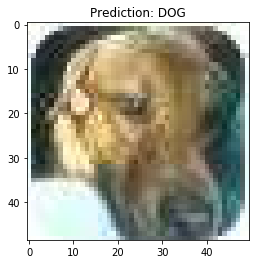

In [87]:
see_test(100)